In [1]:
#!git clone 'https://bitbucket.org/jadslim/german-traffic-signs.git'

In [1]:
import pickle # allows us to work with serilaized data .p (pickled file)
import pandas as pd # allows us to work with .csv file.
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import requests
from PIL import Image

Using TensorFlow backend.


In [3]:
np.random.seed(0)

In [4]:
# Import pickled files and unpickle them using pickle module (with).
# with keyword: used when we want to execute 2 operations as a pair and invoke a block of code in between;
# Open a file --> Manipulate it --> Automatically, close it.
# So, we're going to read a binray file 'rb' and store it as 'f'.
with open("Resources/Datasets/jadslim-german-traffic-signs/train.p", "rb") as f:
    train_data = pickle.load(f)

with open("Resources/Datasets/jadslim-german-traffic-signs/valid.p", "rb") as f:
    val_data = pickle.load(f)
    
with open("Resources/Datasets/jadslim-german-traffic-signs/test.p", "rb") as f:
    test_data = pickle.load(f)
    
    
print(type(train_data))

# features : are corresponds to values of training images and pixel presentation.
# labels: are corresponds to an array of labels which pretty much label each training image as belonging to
#         some class. it helps the neural network learn a function that properly classifies the input data.
X_train, y_train = train_data["features"], train_data["labels"]
X_val, y_val = val_data["features"], val_data["labels"]
X_test, y_test = test_data["features"], test_data["labels"]

<class 'dict'>


In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "Number of images is not equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "Number of images is not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "Number of images is not equal to number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of images are not 32 x 32 x 3"

In [7]:
data = pd.read_csv("Resources/Datasets/jadslim-german-traffic-signs/signnames.csv")
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

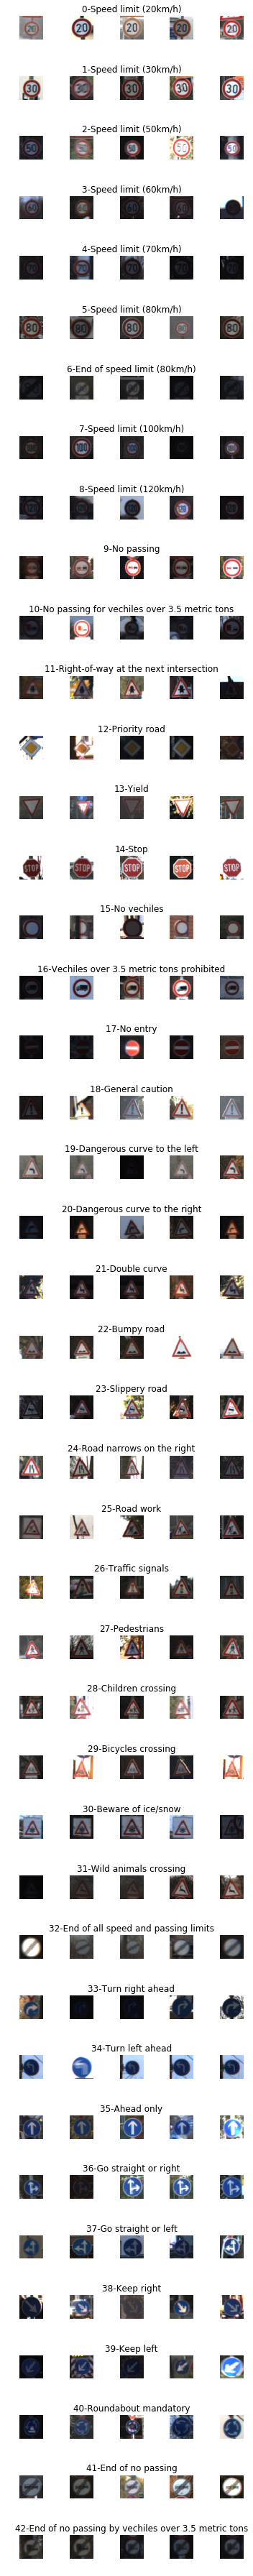

In [8]:
# Just for testing.
num_of_samples = []

cols = 5
num_classes =  43

# Create the grid using plt.subplots() which allows us to display multiple plots on the same figure
# and it returns a tuples which contains 2 values; an instance of our figure and its axis
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
# Automatically minimizes overlapping and interference between axis by using tight_layout().
fig.tight_layout()


for i in range(cols):
    # Iterate over our entire data frame rows as index and series pairs.
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of image')

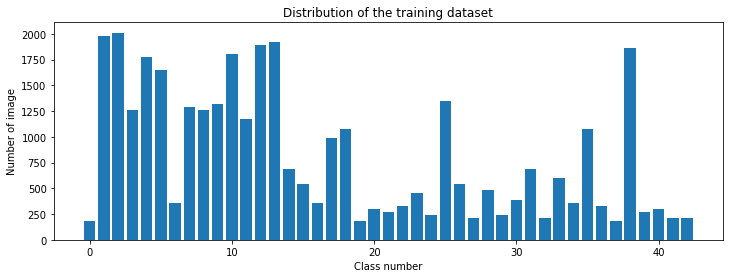

In [9]:
print(num_of_samples)

plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of image")

(32, 32, 3)
36


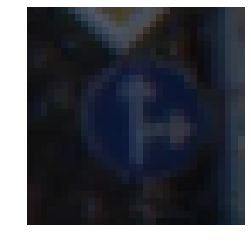

In [10]:
plt.imshow(X_train[1000])
plt.axis("off")

print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


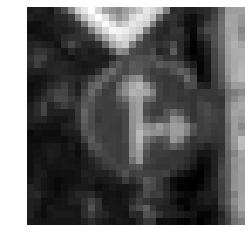

In [11]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


#Just for testing.
img = grayscale(X_train[1000])
plt.imshow(img, cmap = plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

In [12]:
# Preprocessing The Datasets:

# 1.) Histogram equalization aims to standardize the lighting in all our images (to have similar lighting effect)
# Histogram equlaization takes our histogram and spread it at the ends to get a histogram that covers a higher
# range of brightness values and helps to normalize the lighting in all our images. This process also results
# in a higher contrast with our image which can help in features extraction.
# This enhances the contrast in the image such that any grayscale intensities are now better distributed across
# the image at the same time deemphasizing any pixel intensity that occur at high frequncies; it does that by
# theoretically, flattening result in the image histogram as it reassigns gray values in the image.
# [img] should be a grayscale image.
def equalize(img): 
    return cv2.equalizeHist(img)


def preprocess(img):
    img = equalize(grayscale(img))
    # Normalize input image.
    img = img / 255
    return img

(32, 32)


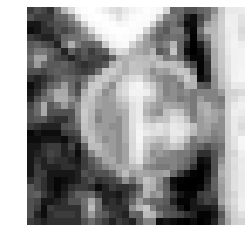

In [13]:
# Just for testing
img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

In [14]:
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32)
(4410, 32, 32)
(12630, 32, 32)


(-0.5, 31.5, 31.5, -0.5)

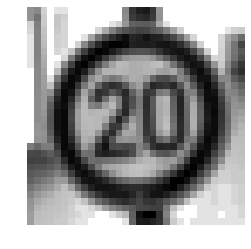

In [15]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap = plt.get_cmap('gray'))
plt.axis("off")

In [16]:
# 2). Adding depth to our datasets (at the moment each image is 2D image which doesn't have depth)
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [17]:
# 2.1) Data augmentaion to add sufficient varaity to our datesets which makes training process more effective.
datagen = ImageDataGenerator(width_shift_range = 0.1, 
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
# Fit augmented data into our data set; image generator will calcaulte any statistics required to actually
# perform these transformation to our datasets (not to all images).
datagen.fit(X_train)

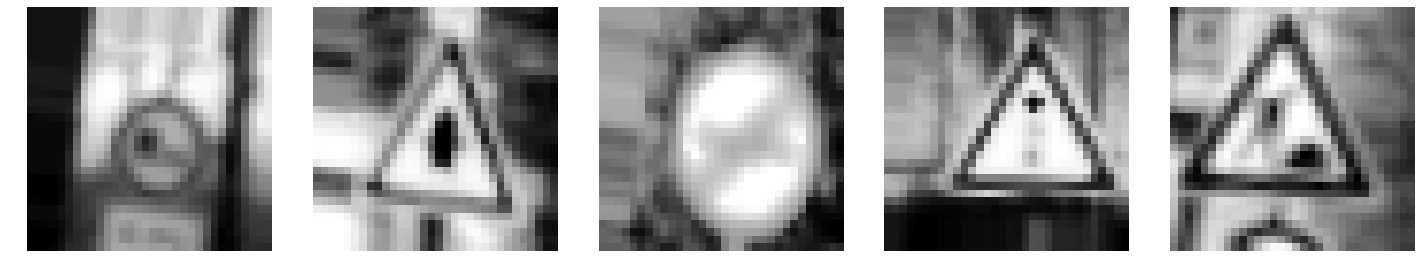

In [18]:
# Just for testing
# Ask the Image generator to create the augmented images.
batches_iterator = datagen.flow(X_train, y_train, batch_size = 20)
# use next() to get our new batches of 20 images (batch_size).
X_batch, y_batch = next(batches_iterator)

fig, axs = plt.subplots(1, 5, figsize = (20, 5))
fig.tight_layout()
for i in range(5):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap = plt.get_cmap("gray"))
    axs[i].axis("off")

In [19]:
# 3). One hot encoded our datasets.
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [20]:
# Create our Convolutional Neural Network
# --> filters count x filterSize x biasValue

def create_model():
    model = Sequential()
    # Add conv. layer Conv2D(howManyFilters, sizeOfFilters, shapeOfOurData, activationFunc, straides, padding)
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = "relu")) 
    model.add(Conv2D(60, (5, 5), activation = "relu")) 
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(30, (3, 3), activation = "relu"))
    model.add(Conv2D(30, (3, 3), activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Flatten our data in order to format it properly to go into the fully connected network.
    model.add(Flatten()) # output --> 1D array.
    model.add(Dense(500, activation = "relu"))
    # Add dropout layer (0.5 -> Drop half of the nodes) to reduce overfitting.
    model.add(Dropout(0.5))
    
    # Add output layer.
    model.add(Dense(num_classes, activation = "softmax"))
    
    # Compile and configure our model.
    model.compile(Adam(lr = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

In [21]:
model = create_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [22]:
# Train our model
#history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 400, shuffle = True)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50),
                              steps_per_epoch = 2000,
                              epochs = 10,
                              validation_data = (X_val, y_val),
                              shuffle = True)

Epoch 1/10
2000/2000 [==============================] - 432s 216ms/step - loss: 0.8641 - acc: 0.7458 - val_loss: 0.0720 - val_acc: 0.9776
Epoch 2/10
2000/2000 [==============================] - 425s 213ms/step - loss: 0.1954 - acc: 0.9387 - val_loss: 0.0520 - val_acc: 0.9846
Epoch 3/10
2000/2000 [==============================] - 430s 215ms/step - loss: 0.1321 - acc: 0.9589 - val_loss: 0.0382 - val_acc: 0.9898
Epoch 4/10
2000/2000 [==============================] - 441s 220ms/step - loss: 0.1011 - acc: 0.9688 - val_loss: 0.0311 - val_acc: 0.9900
Epoch 5/10
2000/2000 [==============================] - 434s 217ms/step - loss: 0.0883 - acc: 0.9733 - val_loss: 0.0251 - val_acc: 0.9932
Epoch 6/10
2000/2000 [==============================] - 433s 217ms/step - loss: 0.0794 - acc: 0.9759 - val_loss: 0.0290 - val_acc: 0.9916
Epoch 7/10
2000/2000 [==============================] - 422s 211ms/step - loss: 0.0692 - acc: 0.9790 - val_loss: 0.0233 - val_acc: 0.9939
Epoch 8/10
2000/2000 [============

Text(0.5, 0, 'epoch')

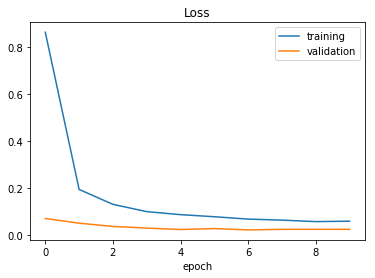

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

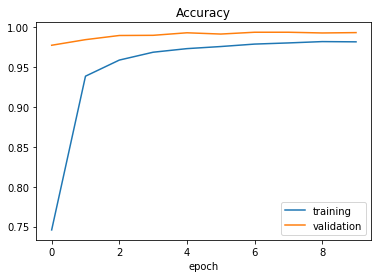

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [25]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

Test Score:  0.12353930070213084
Test Accuracy:  0.9688836104984994


In [26]:
def predict_img(url):
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    #plt.imshow(img, cmap=plt.get_cmap('gray'))
    
    #Preprocess image.
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocess(img)
    #plt.imshow(img, cmap = plt.get_cmap('gray'))
    print(img.shape)
    
    #Reshape reshape
    img = img.reshape(1, 32, 32, 1)

    #Return predicted class.
    return str(model.predict_classes(img))

In [27]:
# Class 1 test?
url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
print("Predicted sign: "+ predict_img(url))

(32, 32)
Predicted sign: [1]


In [28]:
# Class 34 test?
url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
print("Predicted sign: "+ predict_img(url))

(32, 32)
Predicted sign: [34]


In [29]:
# Class 23 test?
url = "https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg"
print("Predicted sign: "+ predict_img(url))

(32, 32)
Predicted sign: [23]


In [30]:
# Class 13 test?
url = "https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg"
print("Predicted sign: "+ predict_img(url))

(32, 32)
Predicted sign: [13]


In [31]:
# Class 29 test?
url = "https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"
print("Predicted sign: "+ predict_img(url))

(32, 32)
Predicted sign: [29]
